<a href="https://colab.research.google.com/github/brunokrp/ai-protectionism/blob/main/exploratory_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SETTING ENVIRONMENT**

### Installing libraries

In [ ]:
!pip install tomotopy
!python -m spacy download en_core_web_lg

In [119]:
from pathlib import Path
import glob

import pandas as pd
import string
import re

import spacy
import en_core_web_lg
from spacy.lang.en.stop_words import STOP_WORDS

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

import sklearn as skl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler

import tomotopy as tp
import seaborn as sns
import geopandas as gpd
import altair as alt
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/"AI INDUSTRIAL POLICY"/"SIPA_TEXT"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AI INDUSTRIAL POLICY/SIPA_TEXT


# **DATA PROCESSING**

#### Preprocessing descriptions

In [74]:
digital_policies_df = pd.read_csv("digital_policies.csv")
digital_policies_df.drop_duplicates(subset=['Latest Event Description'], inplace=True)

In [75]:
stop_list = nltk.corpus.stopwords.words('english')
newStopWords = ['ai','artificial','intelligence', 'technology', 'system', 'systems', 'on', 'machine', 'learning', 'act', 'month', 'day', 'use', 'u', 'state'
                ,'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'approach', 'thresholds', 'report']
stop_list.extend(newStopWords)

In [76]:
lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()  # Get the first letter of the POS tag
    tag_dict = {
        'J': wordnet.ADJ,  # Adjective
        'N': wordnet.NOUN,  # Noun
        'V': wordnet.VERB,  # Verb
        'R': wordnet.ADV    # Adverb
    }
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if not found

In [77]:
def preprocess_policies(text):
    text_tokens = nltk.word_tokenize(text)
    nltk_text = nltk.Text(text_tokens)
    text_lower = [t.lower() for t in nltk_text if t.isalpha()]
    text_stops = [t for t in text_lower if t not in stop_list]
    text_clean = [WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in text_stops]
    text_stops_lemma = [t for t in text_clean if t not in stop_list]

    return ' '.join(text_stops_lemma)

In [78]:
dig_pol_df = digital_policies_df.copy()

# Applying functions to clean policy descriptions
dig_pol_df['clean_event_description'] = dig_pol_df['Latest Event Description'].apply(preprocess_policies)

In [99]:
ai_policies_df = dig_pol_df[(dig_pol_df['Economic Activities'].str.contains('ML and AI development|Semiconductors|cloud computing') == True)].reset_index()
ai_policies_df_per_country = ai_policies_df.assign(countries=ai_policies_df['Implementing Countries'].str.split(', ')).explode('countries').reset_index(drop=True)

In [100]:
len(ai_policies_df)

1062

In [ ]:
ai_policies_df_per_country

#### Creating dataframe with regions/continents per country

In [81]:
cc_df = pd.read_csv('country_continent.csv')
cc_df = cc_df.rename(columns={'country':'countries'})

#### Creating geopandas dataframe with countries shapefile

In [82]:
%cd /content/drive/MyDrive/"AI INDUSTRIAL POLICY"/"SIPA_TEXT"/"WB_countries_Admin0_10m"
gdf = gpd.read_file("WB_countries_Admin0_10m.shp")
gdf = gdf.rename(columns={'WB_NAME':'countries'})

%cd /content/drive/MyDrive/"AI INDUSTRIAL POLICY"/"SIPA_TEXT"

/content/drive/MyDrive/AI INDUSTRIAL POLICY/SIPA_TEXT/WB_countries_Admin0_10m
/content/drive/MyDrive/AI INDUSTRIAL POLICY/SIPA_TEXT


# **AI POLICY TF-IDF**

In [83]:
# Create subsets of data for each region:
tfidf_df = pd.merge(ai_policies_df_per_country,cc_df,on='countries')
list_regions = tfidf_df.region_1.unique()

# Create empty dataframe
tf_idf_regions_terms = pd.DataFrame()

# Calculate TF_IDF for each subset and append to a dataset
for region in list_regions:
  subset = tfidf_df[tfidf_df['region_1'] == region]
  tfidf_vectorizer = TfidfVectorizer(input='content', stop_words=stop_list)
  tfidf_vector = tfidf_vectorizer.fit_transform(subset['Latest Event Description'])
  tfidf_df_subset = pd.DataFrame(tfidf_vector.toarray(), index=subset['Policy Change ID'], columns=tfidf_vectorizer.get_feature_names_out())
  tfidf_df_subset = tfidf_df_subset.stack().reset_index()
  tfidf_df_subset = tfidf_df_subset.rename(columns={0:'tfidf', 'level_1': 'term'})
  tf_idf_regions_terms = pd.concat([tf_idf_regions_terms, tfidf_df_subset])

tf_idf_regions_terms = tf_idf_regions_terms[tf_idf_regions_terms['tfidf'] > 0.001]

In [84]:
# Merge dataset with TF_IDF values with dataset with region and countries
tfidf_df_new = tfidf_df[['Policy Change ID', 'region_1']].drop_duplicates()
tf_idf_regions = pd.merge(tf_idf_regions_terms,tfidf_df_new,on='Policy Change ID')

In [85]:
# Get top 10 terms wwith highest TF_IDF per region
top_tfidf = tf_idf_regions.sort_values(by=['region_1','tfidf'], ascending=[True,False]).drop_duplicates(subset=['term', 'region_1']).groupby(['region_1']).head(10)

In [86]:
# Visualizing TF-IDF

# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'region_1:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["region_1"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + circle + text).properties(width = 600)

alt.LayerChart(...)

# **AI POLICY TOPIC MODELLING**

In [94]:
topic_training_data = ai_policies_df.clean_event_description.to_list()

# Number of topics to return
num_topics = 8

# Number of topic words to print out
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics, seed=42)

# Add each document to the model, after removing white space (strip)
# and splitting it up into words (split)
for text in topic_training_data:
    model.add_doc(text.strip().split())

# The log-likelihood function is typically used to
# derive the maximum likelihood estimator of the parameter
print("Topic Model Training...\n\n")

# Iterate over the data 100 times
iterations = 40
for i in range(0, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

print("\nTopic Model Results:\n\n")
# Print out top 10 words for each topic
topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number+1}✨\n\n{topic_words}\n")

Topic Model Training...


Iteration: 0	Log-likelihood: -7.581507030345364
Iteration: 1	Log-likelihood: -7.493695987730095


<ipython-input-94-47379c959a75>:24: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(iterations)


Iteration: 2	Log-likelihood: -7.464114129558229
Iteration: 3	Log-likelihood: -7.441581269536054
Iteration: 4	Log-likelihood: -7.428933354076105
Iteration: 5	Log-likelihood: -7.428313134106953
Iteration: 6	Log-likelihood: -7.4181145066084415
Iteration: 7	Log-likelihood: -7.425687697991197
Iteration: 8	Log-likelihood: -7.415808159879553
Iteration: 9	Log-likelihood: -7.421224371926906
Iteration: 10	Log-likelihood: -7.417572736042145
Iteration: 11	Log-likelihood: -7.42373203386678
Iteration: 12	Log-likelihood: -7.419453381949495
Iteration: 13	Log-likelihood: -7.422617371255068
Iteration: 14	Log-likelihood: -7.427568627354448
Iteration: 15	Log-likelihood: -7.420053947266181
Iteration: 16	Log-likelihood: -7.408635242187451
Iteration: 17	Log-likelihood: -7.413724246337073
Iteration: 18	Log-likelihood: -7.41337260533669
Iteration: 19	Log-likelihood: -7.413625170365029
Iteration: 20	Log-likelihood: -7.413844737533853
Iteration: 21	Log-likelihood: -7.412673413377749
Iteration: 22	Log-likelihood:

In [172]:
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]
ai_policies_topics = pd.DataFrame(topic_distributions)

In [173]:
ai_policies_df_topics = ai_policies_df.join(ai_policies_topics)

In [183]:
dict_topics = {0:"topic_1", 1:"topic_2", 2:"topic_3", 3:"topic_4", 4:"topic_5", 5:"topic_6", 6:"topic_7", 7:"topic_8"}

In [184]:
ai_policies_country_topics = ai_policies_df_topics.assign(countries=ai_policies_df_topics['Implementing Countries'].str.split(', ')).explode('countries').reset_index(drop=True)
ai_policies_country_topics = pd.merge(ai_policies_country_topics,cc_df[['countries', 'region_1']],on='countries')
ai_policies_country_topics = ai_policies_country_topics.rename(columns=dict_topics)
ai_policies_country_topics = ai_policies_country_topics.drop(columns='countries')

In [206]:
ai_policies_country_topics_only = ai_policies_country_topics.iloc[:,num_topics*(-1)-1:]

In [207]:
ai_policies_country_topics = ai_policies_country_topics_only.groupby(['region_1']).mean()
hist_data = ai_policies_country_topics

<Axes: ylabel='region_1'>

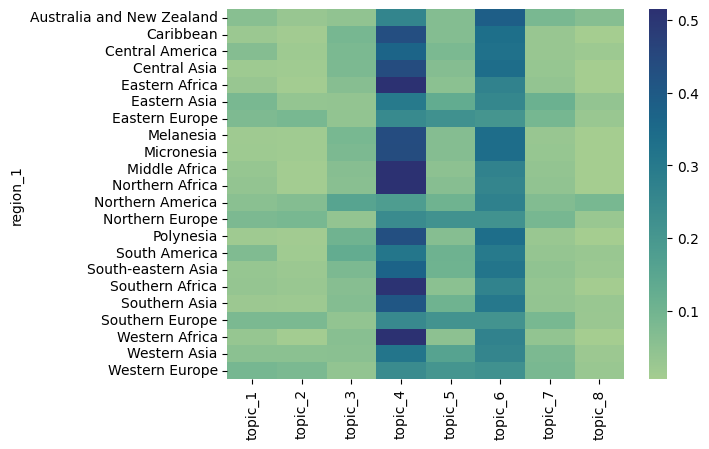

In [208]:
sns.heatmap(hist_data, cmap='crest', robust=True)